In [114]:
import numpy as np
import pandas as pd 
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay



# Get the data

In [115]:
!pip3 install nbformat


%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

In [116]:
print(train_df['Injecao na rede (kWh)'].value_counts())

Injecao na rede (kWh)
None         1654
Medium        241
High          213
Low            87
Very High      61
Name: count, dtype: int64


In [117]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


def neural_network_data_preparation(df: pd.DataFrame,test_or_train) -> pd.DataFrame:
    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    prep_df['Day'] = record_date.day
    prep_df['Year'] = record_date.year

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(train_test_split == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [118]:
X = neural_network_data_preparation(train_df,"train")
test_df = neural_network_data_preparation(test_df,"test").drop('Injecao na rede (kWh)',axis=1)


## 10-Fold Cross Validation

In [119]:
cross_valid_model = SVC(random_state=2023)
y = X['Injecao na rede (kWh)']
X = X.drop('Injecao na rede (kWh)', axis=1)  # Dados de entrada
print(X.head(10))
# Agora, você pode usar X e y na sua validação cruzada
scores = cross_val_score(cross_valid_model, X, y, cv=10)
scores
#scores = cross_val_score(cross_valid_model, test_df, np.ravel(test_df), cv=10)
#scores

   Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)   temp  \
0     0         0.000                    0.486              0.000  16.59   
1     1         0.000                    0.429              0.000  16.59   
2     2         0.000                    0.463              0.000  16.59   
3     3         0.000                    0.545              0.000  13.59   
4     4         0.000                    0.439              0.000  14.97   
5     5         0.000                    0.399              0.000  14.24   
6     6         0.000                    0.398              0.000  13.37   
7     7         0.000                    0.396              0.000  15.56   
8     8         0.349                    0.000              0.048  15.26   
9     9         0.272                    0.000              0.156  14.94   

   feels_like  temp_min  temp_max  pressure  humidity  wind_speed  rain_1h  \
0       16.00     16.21     16.72      1024        65        3.15      0.0   
1      

array([0.73451327, 0.73451327, 0.73451327, 0.73451327, 0.7300885 ,
       0.7300885 , 0.73333333, 0.73333333, 0.73333333, 0.73333333])

In [120]:
print("%0.2f accuracy with a standard deviation of %0.2f"%(scores.mean(),scores.std()))


0.73 accuracy with a standard deviation of 0.00


## Hold Out


In [121]:
model= SVC(random_state=25112002)
model.fit(X,y)
predictions=model.predict(X)


<function matplotlib.pyplot.show(close=None, block=None)>

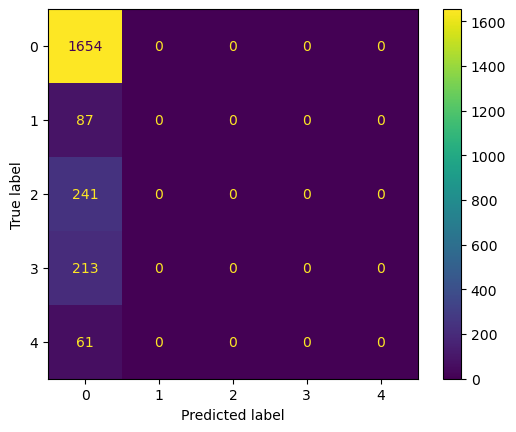

In [122]:
ConfusionMatrixDisplay.from_predictions(y, predictions)
plt.show

## Grid Search

In [123]:
param_grid = {'C':[0.1,1,10,100],'gamma':[1,0.1,0.01],'kernel':['rbf']}
grid = GridSearchCV(SVC(random_state=25112002),param_grid,refit=True,verbose=3,cv=2)
grid.fit(X,y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END ........C=0.1, gamma=1, kernel=rbf;, score=0.733 total time=   0.5s
[CV 2/2] END ........C=0.1, gamma=1, kernel=rbf;, score=0.733 total time=   0.5s
[CV 1/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 2/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.3s
[CV 1/2] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.733 total time=   0.1s
[CV 2/2] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.733 total time=   0.1s
[CV 1/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.5s
[CV 2/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.5s
[CV 1/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 2/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.733 total time=   0.4s
[CV 1/2] END .......C=1, gamma=0.01, kernel=rbf;, score=0.752 total time=   0.1s
[CV 2/2] END .......C=1, gamma=0.01, kernel=rbf;

GridSearchCV(cv=2, estimator=SVC(random_state=25112002),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=3)

In [124]:
grid.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [125]:
grid.best_estimator_


SVC(C=1, gamma=0.01, random_state=25112002)

In [126]:
predictions= grid.best_estimator_.predict(X)


In [127]:
print(confusion_matrix(y,predictions))
print('Accuracy',metrics.accuracy_score(y,predictions))
print('F1 score',f1_score(y,predictions, average='micro'))
print('Recall score',recall_score(y,predictions,average='micro'))

[[1645    0    7    2    0]
 [  68    4   10    5    0]
 [ 101    1  120   19    0]
 [  32    0   24  157    0]
 [  10    0    6   26   19]]
Accuracy 0.862145390070922
F1 score 0.862145390070922
Recall score 0.862145390070922


In [128]:
predictions= grid.best_estimator_.predict(test_df)

predictions_df = pd.DataFrame(predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}

predictions_df.replace(numerical_to_categorical, inplace=True)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')